<a href="https://colab.research.google.com/github/mkirby1995/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/LS_DS_242_Review_and_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science — Practicing & Understanding Predictive Modeling_

# Review & Regularization

## Start with example solution for yesterday's assignment

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
# We'll modify a project from Python Data Science Handbook by Jake VanderPlas
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic
    
# Predicting Bicycle Traffic

# As an example, let's take a look at whether we can predict the number of 
# bicycle trips across Seattle's Fremont Bridge based on weather, season, 
# and other factors.

# We will join the bike data with another dataset, and try to determine the 
# extent to which weather and seasonal factors—temperature, precipitation, 
# and daylight hours—affect the volume of bicycle traffic through this corridor. 
# Fortunately, the NOAA makes available their daily weather station data 
# (I used station ID USW00024233) and we can easily use Pandas to join 
# the two data sources.

def load(): 
    fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
    
    bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                         infer_datetime_format=True)

    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                          infer_datetime_format=True)

    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']] # remove other columns

    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    daily = daily.drop(index=daily.index[0])
    
    return daily

In [0]:
def split(daily):
    # Hold out an "out-of-time" test set, from the last 100 days of data
    
    train = daily[:-100]
    test = daily[-100:]
    
    X_train = train.drop(columns='Total')
    y_train = train.Total

    X_test  = test.drop(columns='Total')
    y_test  = test.Total
    ""
    return X_train, X_test, y_train, y_test

In [0]:
def jake_wrangle(X):  
    X = X.copy()

    # patterns of use generally vary from day to day; 
    # let's add binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)


    # we might expect riders to behave differently on holidays; 
    # let's add an indicator of this as well:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)


    # We also might suspect that the hours of daylight would affect 
    # how many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))


    # temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMAX'] /= 10

    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])


    # precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry day'] = (X['PRCP'] == 0).astype(int)


    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.

    return X

In [0]:
# Download and join data into a dataframe
data = load()

#### `SNOW` and `AWND` have minimums of `-9999` ...

In [0]:
data.describe(include='number')

,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,2632.449671,29.350894,-37.496707,0.098777,166.863594,84.472248,22.338664,2633.056444
std,1252.864020,65.813053,612.512583,2.570041,74.779734,50.916006,307.984292,1253.138245
min,98.000000,0.000000,-9999.000000,0.000000,-16.000000,-71.000000,-9999.000000,98.000000
25%,1806.000000,0.000000,0.000000,0.000000,111.000000,44.000000,22.000000,1806.000000
50%,2435.000000,0.000000,0.000000,0.000000,150.000000,83.000000,29.000000,2435.000000
75%,3574.500000,26.500000,0.000000,0.000000,222.000000,128.000000,40.000000,3574.500000
max,6088.000000,559.000000,74.000000,80.000000,356.000000,183.000000,95.000000,6088.000000


### Clean data and engineer features

In [0]:
def wrangle(X):
    X = X.copy()
    X = X.replace(-9999, 0)
    X = jake_wrangle(X)
    
    # DS1 DH
    X['PRCP_yesterday'] = X.PRCP.shift(1).fillna(X.PRCP.mean())
    X['Windchill'] = (((X['Temp (C)'] * (9/5) + 32) * .6215) + 34.74) - (35.75 * (X['AWND']** .16)) + (.4275 * (X['Temp (C)'])) * (X['AWND'] ** .16)
    X['Rl_Cold'] = (((X['Temp (C)'] * (9/5) + 32) - X['Windchill']) -32) * (5/9)
    X['TMIN_squared'] = X['TMIN'] **2
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i, month in enumerate(months):
        X[month] = (X.index.month == i+1).astype(float)
    
    # DS3 JD
    X['light_rain'] = (X['PRCP'] > 0) & (X['PRCP'] < 0.10)
    X['moderate_rain'] = (X['PRCP'] >= 0.1) & (X['PRCP'] < 0.30)
    X['heavy_rain'] = (X['PRCP'] >= 0.30)
    X['weekend_day'] = (X['Sat'] == 1) | (X['Sun'] == 1)

    return X

In [0]:
# Split data into train and test
X_train, X_test, y_train, y_test = split(data)

# Do the same wrangling to X_train and X_test
X_train = wrangle(X_train)
X_test  = wrangle(X_test)

### RandomizedSearchCV review / SPRINT CHALLENGE PRACTICE
- https://twitter.com/jakevdp/status/648593367786323968
- https://www.google.com/search?q=site%3Ascikit-learn.org+RandomizedSearchCV
  - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
  - https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
- https://www.google.com/search?q=XGBRegressor
  - https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://www.google.com/search?q=xgboost+parameter+tuning
  - https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
- https://nbviewer.jupyter.org/github/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb

In [0]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

param_distributions = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(1,5)
}

search = RandomizedSearchCV(estimator = XGBRegressor(n_jobs=-1, random_state=42),
                            param_distributions = param_distributions,
                            n_iter=50,
                           scoring='neg_mean_absolute_error',
                           n_jobs=-1,
                           cv=3,
                           verbose=10,
                           return_train_score=True)

search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5e84064f28>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5e84064cc0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [0]:
-search.best_score_

264.24135861342324

In [0]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
6,0.263791,0.005731,0.005736,0.000025,4,120,"{'max_depth': 4, 'n_estimators': 120}",-240.772781,-299.877372,-252.073922,-264.241359,25.617352,1,-105.464731,-100.526975,-104.150959,-103.380888,2.088080
21,0.191439,0.008185,0.005103,0.000115,4,83,"{'max_depth': 4, 'n_estimators': 83}",-237.180462,-300.742311,-255.899404,-264.607393,26.669570,2,-129.499986,-120.511754,-126.332307,-125.448016,3.722325
17,0.187099,0.006896,0.005117,0.000130,4,82,"{'max_depth': 4, 'n_estimators': 82}",-237.071466,-300.763947,-255.987096,-264.607503,26.707260,3,-129.883332,-120.927884,-126.701792,-125.837669,3.706755
34,0.267881,0.007746,0.005815,0.000195,2,209,"{'max_depth': 2, 'n_estimators': 209}",-239.379270,-304.888646,-257.432574,-267.233497,27.627440,4,-180.874221,-173.108919,-178.953564,-177.645568,3.302334
14,0.209317,0.008115,0.005315,0.000142,3,120,"{'max_depth': 3, 'n_estimators': 120}",-243.247426,-304.436923,-254.365299,-267.349883,26.614385,5,-155.754275,-149.467524,-155.145668,-153.455822,2.831077
25,0.303182,0.005963,0.006137,0.000219,2,247,"{'max_depth': 2, 'n_estimators': 247}",-241.997165,-302.380834,-259.491144,-267.956381,25.367854,6,-173.207968,-164.324200,-170.302676,-169.278282,3.698412
16,0.354677,0.005030,0.006626,0.000157,2,285,"{'max_depth': 2, 'n_estimators': 285}",-241.632089,-303.091289,-259.304524,-268.009301,25.834579,7,-166.933055,-156.591561,-163.067533,-162.197383,4.266497
27,0.421268,0.011587,0.007138,0.000092,4,191,"{'max_depth': 4, 'n_estimators': 191}",-251.738956,-302.406824,-251.187161,-268.444313,24.016178,8,-75.067608,-75.176873,-78.341780,-76.195420,1.518361
28,0.298522,0.013777,0.005955,0.000186,3,168,"{'max_depth': 3, 'n_estimators': 168}",-244.862093,-306.853908,-254.697397,-268.804466,27.202981,9,-133.966095,-131.721537,-134.865301,-133.517644,1.322030
41,0.285055,0.012686,0.005937,0.000164,3,167,"{'max_depth': 3, 'n_estimators': 167}",-244.927903,-306.850678,-254.904207,-268.894263,27.146501,10,-134.412945,-131.962992,-135.281471,-133.885803,1.405106


In [0]:
search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=120, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

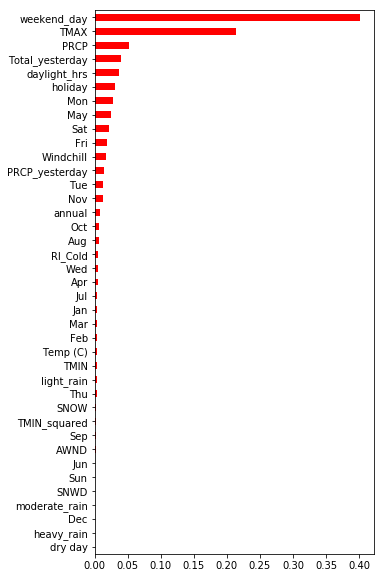

In [0]:
plt.figure(figsize=(5,10))
importances = pd.Series(search.best_estimator_.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='red');

### Take the last step

Yesterday's assingment said,

At the end of the day, take the last step in the "universal workflow of machine learning" — "You can train your final production model on all the available data (training and validation) and evaluate it one last time on the test set."

See the [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) documentation for the `refit` parameter, `best_estimator_` attribute, and `predict` method:

> **refit : boolean, or string, default=True**

> Refit an estimator using the best found parameters on the whole dataset.

> The refitted estimator is made available at the `best_estimator_` attribute and permits using `predict` directly on this `GridSearchCV` instance.

In [0]:
from sklearn.metrics import mean_absolute_error

final = search.best_estimator_
y_pred = final.predict(X_test)
test_mse = mean_absolute_error(y_test, y_pred)
print(test_mse)

251.27920837402343


## A few new things!
- Pipeline + RandomizedSearchCV
- SelectKBest for feature selection, in a pipeline
- Ridge Regression, a linear model with regularization

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge
from sklearn.feature_selection import f_regression, SelectKBest


pipe = make_pipeline(
    RobustScaler(),
    SelectKBest(f_regression),
    Ridge())


param_distributions = {
    'selectkbest__k':range(1, len(X_train.columns)+1),
    'ridge__alpha': [0.1, 1., 10.]
}

search = RandomizedSearchCV(estimator = pipe,
                            param_distributions = param_distributions,
                            n_iter=100,
                            scoring='neg_mean_absolute_error',
                            n_jobs=-1,
                            cv=5,
                            verbose=10,
                            return_train_score=True)
 
search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0388s.) Setting batch_size=10.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 424 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequa

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=10, score_func=<function f_regression at 0x7f5e764f1e18>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'selectkbest__k': range(1, 40), 'ridge__alpha': [0.1, 1.0, 10.0]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [0]:
# Shows which features were selected
selector = search.best_estimator_.named_steps['selectkbest']
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\n', 'Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
PRCP
TMAX
TMIN
AWND
Total_yesterday
Mon
Tue
Wed
Thu
Sat
Sun
holiday
daylight_hrs
Temp (C)
dry day
annual
PRCP_yesterday
Windchill
Rl_Cold
TMIN_squared
Jan
Feb
Mar
May
Jun
Jul
Aug
Nov
Dec
light_rain
moderate_rain
heavy_rain
weekend_day

 Features not selected:
SNOW
SNWD
Fri
Apr
Sep
Oct


## Regularization with Linear Models

- https://www.google.com/search?q=site%3Ascikit-learn.org+regularization+%22linear+models%22
  - https://scikit-learn.org/stable/modules/linear_model.html
  - https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression
  - https://scikit-learn.org/stable/modules/linear_model.html#lasso
  - https://scikit-learn.org/stable/modules/linear_model.html#setting-regularization-parameter
  - https://scikit-learn.org/stable/modules/linear_model.html#using-cross-validation
    
> The [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer non-zero coefficients, effectively reducing the number of features upon which the given solution is dependent. 
  
> The `alpha` parameter controls the degree of sparsity of the estimated coefficients.
  
> scikit-learn exposes objects that set the Lasso `alpha` parameter by cross-validation: [`LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV) ...

In [0]:
from ipywidgets import interact
from sklearn.exceptions import DataConversionWarning
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

def plot_lasso_coefs(power=-2):
    # Make pipeline with StandardScaler and Lasso Linear Model
    alpha = 10**power
    print(f'Lasso Alpha: {alpha}')
    pipe = make_pipeline(StandardScaler(), Lasso(alpha=alpha, max_iter=100000))
    
    # Get cross-validation scores
    maes = -cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=3)
    print('Cross-Validated Mean Absolute Error:', maes.mean())
    
    # Get coefficients
    pipe.fit(X_train, y_train)
    coefficients = pd.Series(pipe.named_steps['lasso'].coef_, X_train.columns)
    
    # Plot coefficients
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-550,550)

interact(plot_lasso_coefs, power=(-2,2,1));

interactive(children=(IntSlider(value=-2, description='power', max=2, min=-2), Output()), _dom_classes=('widge…

In [0]:
from sklearn.linear_model import LassoCV

pipe = make_pipeline(StandardScaler(), LassoCV(cv=3))
pipe.fit(X_train, y_train)
lasso = pipe.named_steps['lassocv']
print('Lasso Linear Model, alpha value optimized with cross validation:', lasso.alpha_)

Lasso Linear Model, alpha value optimized with cross validation: 5.196217086880751


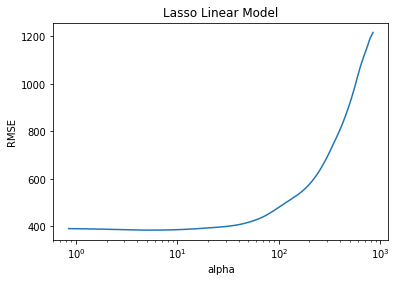

In [0]:
alphas = lasso.alphas_
mses = lasso.mse_path_.mean(axis=1)
rmses = np.sqrt(mses)
plt.plot(alphas, rmses)
plt.title('Lasso Linear Model')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.xscale('log');

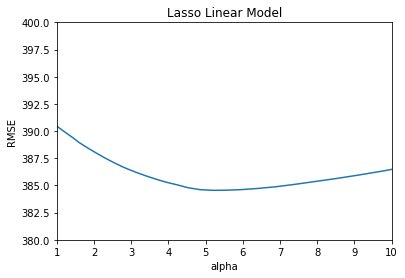

In [0]:
plt.plot(alphas, rmses)
plt.title('Lasso Linear Model')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.xlim(1,10)
plt.ylim(380,400);

## Want to learn more about regularized linear models?
- Aaron Gallant, [Ridge Regression](https://www.youtube.com/watch?v=XK5jkedy17w) (9 minute video)
- Selecting good features, [Part 2](https://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/) and [Part 4](https://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/)
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/), Chapters 3 & 6